In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

# Load SMS Spam dataset from uploaded file
df = pd.read_csv("spam.csv", encoding="latin1")[["v1","v2"]]
df.columns = ["label","text"]

# Convert labels
df["label"] = df["label"].map({"ham":0,"spam":1})

# Clean text
def clean_text(t):
    t = t.lower()
    t = re.sub(f"[{string.punctuation}]", " ", t)
    return t

df["clean_text"] = df["text"].apply(clean_text)

# TF-IDF
tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(df["clean_text"])
y = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Class Distribution:\n", df["label"].value_counts())

Class Distribution:
 label
0    4825
1     747
Name: count, dtype: int64


In [15]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("\n=== DECISION STUMP BASELINE ===")
print("Train Accuracy:", accuracy_score(y_train, stump.predict(X_train)))
print("Test Accuracy:", accuracy_score(y_test, stump.predict(X_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, stump.predict(X_test)))



=== DECISION STUMP BASELINE ===
Train Accuracy: 0.8918555081893651
Test Accuracy: 0.8869955156950673
Confusion Matrix:
 [[961   5]
 [121  28]]



Iteration 1
Misclassified indices: [  9  15  22  31  39  49  59  66  76  88  93 114] ...
Weights of misclassified samples: [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0549179560565716

Iteration 2
Misclassified indices: [ 9 15 22 31 39 49 50 59 62 66 76 86] ...
Weights of misclassified samples: [0.00053585 0.00053585 0.00053585 0.00053585 0.00053585 0.00053585
 0.0001866  0.00053585 0.0001866  0.00053585]
Alpha: 0.5949308344452364

Iteration 3
Misclassified indices: [15 31 39 49 50 59 66 76 86 88 93 96] ...
Weights of misclassified samples: [0.0008166  0.0008166  0.0008166  0.0008166  0.00028436 0.0008166
 0.0008166  0.0008166  0.00028436 0.0008166 ]
Alpha: 0.3827807021351148

Iteration 4
Misclassified indices: [ 9 15 22 31 39 49 50 59 62 66 76 86] ...
Weights of misclassified samples: [0.0007113  0.00104301 0.0007113  0.00104301 0.00104301 0.00104301
 0.0003632  0.00104301 0.00024769 0.00104301]
Alpha: 0.19

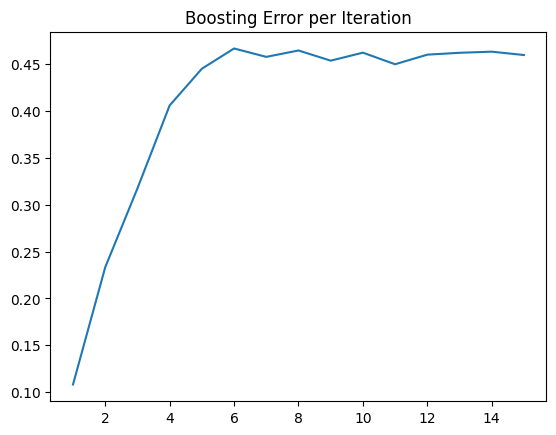

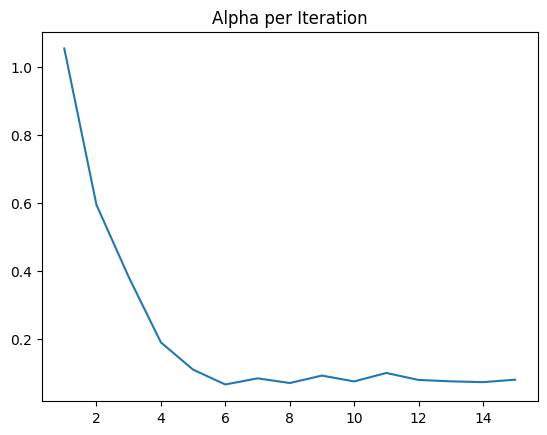


=== Manual AdaBoost Results ===
Train Accuracy: 0.8918555081893651
Test Accuracy: 0.8869955156950673
Confusion Matrix:
 [[961   5]
 [121  28]]


In [16]:
T = 15
n = X_train.shape[0]
weights = np.ones(n) / n

alphas = []
errors = []

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train, sample_weight=weights)

    pred = stump_t.predict(X_train)
    misclassified = (pred != y_train)

    err = np.sum(weights * misclassified)
    errors.append(err)

    alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
    alphas.append(alpha)

    print(f"\nIteration {t+1}")
    print("Misclassified indices:", np.where(misclassified)[0][:12], "...")
    print("Weights of misclassified samples:", weights[misclassified][:10])
    print("Alpha:", alpha)

    weights *= np.exp(alpha * misclassified)
    weights /= weights.sum()

# Plots
plt.plot(range(1,T+1), errors)
plt.title("Boosting Error per Iteration")
plt.show()

plt.plot(range(1,T+1), alphas)
plt.title("Alpha per Iteration")
plt.show()

# Final Predictions
final_train = np.zeros_like(y_train, float)
final_test = np.zeros_like(y_test, float)

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train)
    final_train += alphas[t] * stump_t.predict(X_train)
    final_test += alphas[t] * stump_t.predict(X_test)

final_train = (final_train >= 0.5).astype(int)
final_test = (final_test >= 0.5).astype(int)

print("\n=== Manual AdaBoost Results ===")
print("Train Accuracy:", accuracy_score(y_train, final_train))
print("Test Accuracy:", accuracy_score(y_test, final_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, final_test))


In [17]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
ada.fit(X_train, y_train)

print("\n=== SKLEARN ADABOOST ===")
print("Train:", accuracy_score(y_train, ada.predict(X_train)))
print("Test:", accuracy_score(y_test, ada.predict(X_test)))
print("Confusion Matrix:\n", confusion_matrix(y_test, ada.predict(X_test)))



=== SKLEARN ADABOOST ===
Train: 0.9046443796275522
Test: 0.905829596412556
Confusion Matrix:
 [[966   0]
 [105  44]]


In [18]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Load
heart = load_breast_cancer()
X = heart.data
y = heart.target

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("\n=== HEART — Decision Stump ===")
print("Train Acc:", accuracy_score(y_train, stump.predict(X_train)))
print("Test Acc:", accuracy_score(y_test, stump.predict(X_test)))
print(confusion_matrix(y_test, stump.predict(X_test)))
print(classification_report(y_test, stump.predict(X_test)))


=== HEART — Decision Stump ===
Train Acc: 0.9208791208791208
Test Acc: 0.8947368421052632
[[39  4]
 [ 8 63]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        43
           1       0.94      0.89      0.91        71

    accuracy                           0.89       114
   macro avg       0.89      0.90      0.89       114
weighted avg       0.90      0.89      0.90       114



In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Load
heart = load_breast_cancer()
X = heart.data
y = heart.target

# Scale
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("\n=== HEART — Decision Stump ===")
print("Train Acc:", accuracy_score(y_train, stump.predict(X_train)))
print("Test Acc:", accuracy_score(y_test, stump.predict(X_test)))
print(confusion_matrix(y_test, stump.predict(X_test)))
print(classification_report(y_test, stump.predict(X_test)))


=== HEART — Decision Stump ===
Train Acc: 0.9208791208791208
Test Acc: 0.8947368421052632
[[39  4]
 [ 8 63]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        43
           1       0.94      0.89      0.91        71

    accuracy                           0.89       114
   macro avg       0.89      0.90      0.89       114
weighted avg       0.90      0.89      0.90       114



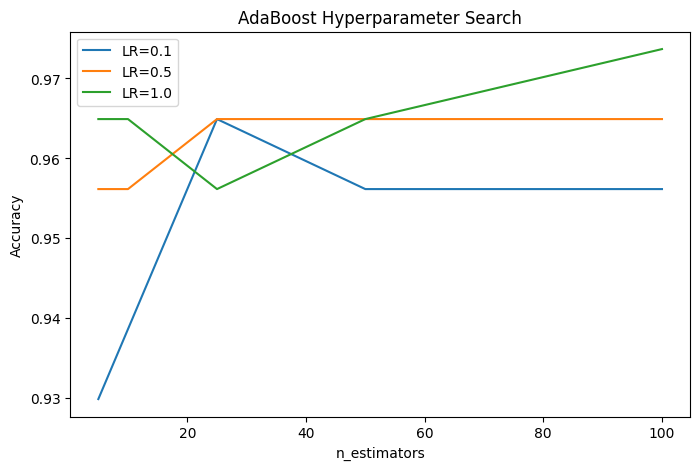

Best Config: (100, 1.0) Accuracy = 0.9736842105263158


In [20]:
n_estimators_list = [5,10,25,50,100]
lr_list = [0.1,0.5,1.0]

results = {}

plt.figure(figsize=(8,5))

for lr in lr_list:
    acc_list = []
    for n_est in n_estimators_list:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr
        )
        ada.fit(X_train, y_train)
        acc = accuracy_score(y_test, ada.predict(X_test))
        acc_list.append(acc)
        results[(n_est,lr)] = acc
    plt.plot(n_estimators_list, acc_list, label=f"LR={lr}")

plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("AdaBoost Hyperparameter Search")
plt.show()

best_cfg = max(results, key=results.get)
print("Best Config:", best_cfg, "Accuracy =", results[best_cfg])


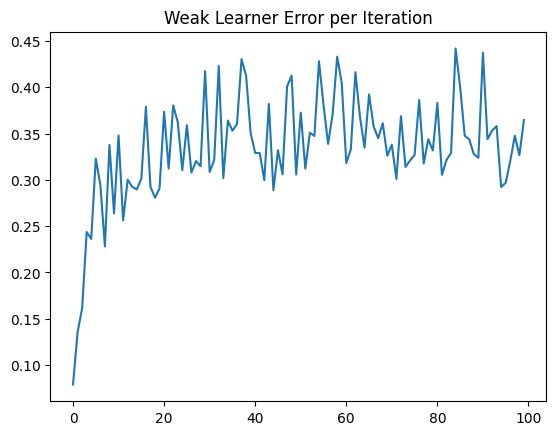

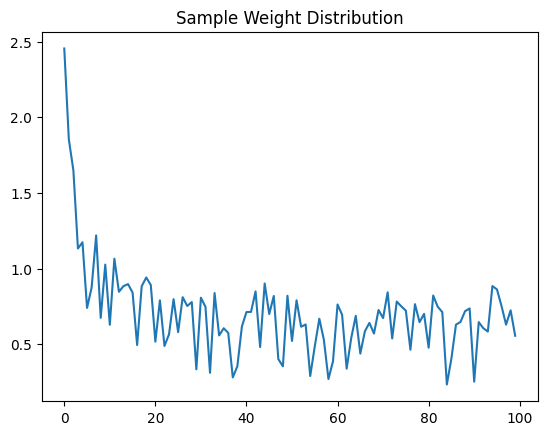


Top 5 Important Features:
worst area : 0.0993364699983836
worst symmetry : 0.09547400230412072
worst texture : 0.07795213871510308
mean concave points : 0.07718337743197655
compactness error : 0.07631350466917038


In [21]:
best_n, best_lr = best_cfg

ada_best = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr
)
ada_best.fit(X_train, y_train)

plt.plot(ada_best.estimator_errors_)
plt.title("Weak Learner Error per Iteration")
plt.show()

plt.plot(ada_best.estimator_weights_)
plt.title("Sample Weight Distribution")
plt.show()

importances = ada_best.feature_importances_
idx = np.argsort(importances)[::-1][:5]

print("\nTop 5 Important Features:")
for i in idx:
    print(heart.feature_names[i], ":", importances[i])


In [22]:
# Load the WISDM text file uploaded earlier
wisdm = []

with open("WISDM_ar_v1.1_raw.txt") as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) < 6:
            continue
        user, activity, t, x, y, z = parts[:6]
        try:
            wisdm.append([activity, float(x), float(y), float(z)])
        except:
            continue

df = pd.DataFrame(wisdm, columns=["Activity","X","Y","Z"])

# Map labels
vigorous = ["Jogging","Upstairs"]
df["label"] = df["Activity"].apply(lambda a: 1 if a in vigorous else 0)

X = df[["X","Y","Z"]].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(df.head())


  Activity     X      Y     Z  label
0  Walking  0.65   9.51  5.13      0
1  Walking  1.73  12.11  7.65      0
2  Walking  1.42  11.18  8.43      0
3  Walking -3.60   9.77  2.68      0
4  Walking -2.18   4.40  2.14      0


In [23]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

print("\n=== WISDM STUMP ===")
print("Train:", accuracy_score(y_train, stump.predict(X_train)))
print("Test:", accuracy_score(y_test, stump.predict(X_test)))
print(confusion_matrix(y_test, stump.predict(X_test)))



=== WISDM STUMP ===
Train: 0.6573724582978205
Test: 0.6607954545454545
[[1817    2]
 [1192  509]]



Round 1
Misclassified: [ 0  5  9 11 14 19 22 24 26 30]
Weights: [0.00012176 0.00012176 0.00012176 0.00012176 0.00012176 0.00012176
 0.00012176 0.00012176 0.00012176 0.00012176]

Round 2
Misclassified: [ 0  5  9 11 14 19 22 24 26 30]
Weights: [0.00014899 0.00014899 0.00014899 0.00014899 0.00014899 0.00014899
 0.00014899 0.00014899 0.00014899 0.00014899]

Round 3
Misclassified: [ 1  2  3  4  6  8 10 13 17 18]
Weights: [0.00010014 0.00010014 0.00010014 0.00010014 0.00010014 0.00010014
 0.00010014 0.00010014 0.00010014 0.00010014]

Round 4
Misclassified: [ 5  7 12 15 16 24 26 30 33 35]
Weights: [1.51984575e-04 9.32304086e-05 9.32304086e-05 9.32304086e-05
 9.32304086e-05 1.51984575e-04 1.51984575e-04 1.51984575e-04
 9.32304086e-05 1.51984575e-04]

Round 5
Misclassified: [ 1  2  3  4  6  8 10 13 17 18]
Weights: [0.00010085 0.00010085 0.00010085 0.00010085 0.00010085 0.00010085
 0.00010085 0.00010085 0.00010085 0.00010085]

Round 6
Misclassified: [ 0  5  9 11 14 19 22 24 26 30]
Weights: [0.0

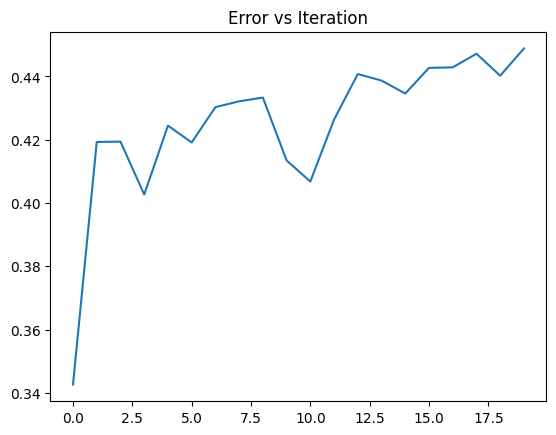

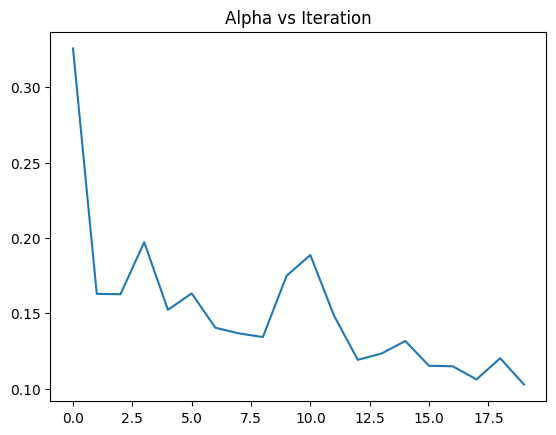


=== WISDM MANUAL ADABOOST ===
Train: 0.6573724582978205
Test: 0.6607954545454545
[[1817    2]
 [1192  509]]


In [24]:
T = 20
n = X_train.shape[0]
weights = np.ones(n)/n
alphas = []
errors = []

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train, sample_weight=weights)

    pred = stump_t.predict(X_train)
    mis = (pred != y_train)

    err = np.sum(weights * mis)
    errors.append(err)

    alpha = 0.5*np.log((1-err)/(err+1e-10))
    alphas.append(alpha)

    print("\nRound", t+1)
    print("Misclassified:", np.where(mis)[0][:10])
    print("Weights:", weights[mis][:10])

    weights *= np.exp(alpha*mis)
    weights /= weights.sum()

plt.plot(errors); plt.title("Error vs Iteration"); plt.show()
plt.plot(alphas); plt.title("Alpha vs Iteration"); plt.show()

# Final prediction
final_train = np.zeros_like(y_train, float)
final_test = np.zeros_like(y_test, float)

for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train)
    final_train += alphas[t] * stump_t.predict(X_train)
    final_test += alphas[t] * stump_t.predict(X_test)

final_train = (final_train >= 0.5).astype(int)
final_test = (final_test >= 0.5).astype(int)

print("\n=== WISDM MANUAL ADABOOST ===")
print("Train:", accuracy_score(y_train, final_train))
print("Test:", accuracy_score(y_test, final_test))
print(confusion_matrix(y_test, final_test))


In [25]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0
)
ada.fit(X_train, y_train)

print("\n=== SKLEARN WISDM ADABOOST ===")
print("Train:", accuracy_score(y_train, ada.predict(X_train)))
print("Test:", accuracy_score(y_test, ada.predict(X_test)))
print(confusion_matrix(y_test, ada.predict(X_test)))



=== SKLEARN WISDM ADABOOST ===
Train: 0.8289297455253866
Test: 0.8403409090909091
[[1717  102]
 [ 460 1241]]
